In [1]:
import numpy as np
from copy import copy
from typing import Mapping
from typing import Callable
from matplotlib import pyplot as plt
from matplotlib import cm
from celluloid import Camera
from numba import njit

In [2]:
def test_function_1(x: np.ndarray) -> float:
    '''
    Функция Бута
    '''
    return (x[0] + 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2

In [3]:
def test_function_2(x: np.ndarray) -> float:
    '''
    Функция Розенброка
    '''
    return 100 * (x[1] - x[0] ** 2) ** 2 + (x[0] - 1) ** 2

In [4]:
def tf1_draw(x, y):
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

In [5]:
def tf2_draw(x, y):
    return 100 * (y - x ** 2) ** 2 + (x - 1) ** 2

In [6]:
BoothFunction: Mapping[str, Callable] = {
    'request'  : test_function_1,
    'draw'     : tf1_draw,
    'solution' : lambda: np.array([1, 3])
}

RosenbrokFunction: Mapping[str, Callable] = {
    'request'  : test_function_2,
    'draw'     : tf2_draw,
    'solution' : lambda: np.array([1, 1])
}

In [11]:
class Domain:
    
    def __init__(self, left_border: np.ndarray, right_border: np.ndarray):
        self.__lb = left_border
        self.__rb = right_border
        
    def is_in_domain(self, x: np.ndarray) -> bool:
        statement_1 = x >= self.__lb
        statement_2 = x <= self.__rb
        
        return statement_1.all() and statement_2.all()

    def get_left_bounds(self):
        return self.__lb

    def get_right_bounds(self):
        return self.__rb

In [12]:
class Plot:
    def __init__(self, 
                 function: Mapping[str, Callable], 
                 domain: Domain):
        self.__function   = function
        self.__domain     = domain

    def render(self):
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        lb = self.__domain.get_left_bounds()
        rb = self.__domain.get_right_bounds()
        x = np.linspace(lb[0], rb[0])
        y = np.linspace(lb[1], rb[1])
        xg, yg = np.meshgrid(x, y)
        z = self.__function['draw'](xg, yg)
        surf = ax.plot_surface(xg, yg, z, cmap = cm.plasma, linewidth = 0, antialiased = False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()

In [15]:
class FirstOrderOracle():
    
    def __init__(self, function: Mapping[str, Callable], domain: Domain):
        self.__func   = function
        self.__domain = domain
    
    def query(self, x: np.ndarray, step: float = 1e-9) -> (float, np.ndarray):
        fn: float  = np.inf
        drv: np.ndarray = np.zeros(len(x))
            
        if self.__domain.is_in_domain(x):
            fn: float = (self.__func['request'])(x)
            
            for i in range(len(x)):
                delta = np.zeros(len(x))
                delta[i] = step
                drv[i] = (self.__func['request'](x + delta) - fn) / step

        return fn, drv

    def solution(self):
        return self.__func['solution'](), self.__func['request'](self.__func['solution']())

In [56]:
class GradientDescent():
    
    def __init__(self, 
                 oracle,
                 initial_point: np.ndarray, 
                 learning_rate: float = 1e-3,
                 accuracy: float = 1e-3,
                 max_iter: int   = 1e+3):
        self.__oracle        = oracle
        self.__init_point    = initial_point
        self.__lr            = learning_rate
        self.__acc           = accuracy
        self.__max_iter      = max_iter
        self.__found_p       = np.zeros(len(initial_point))
        self.__fount_fn      = 0.0
    
    def step(self, current_point: np.ndarray) -> np.ndarray:
        _, drv = self.__oracle.query(current_point)
        next_point = current_point - self.__lr * drv
        return next_point
        
    def solve(self):
        traj = []
        prev_point = copy(self.__init_point)
        next_point = self.step(prev_point)
        counter = 0
        
        traj.append(self.__init_point)
        traj.append(next_point)
        while np.linalg.norm(prev_point - next_point) >= self.__acc and counter < self.__max_iter:
            prev_point = next_point
            next_point = self.step(prev_point)
            traj.append(next_point)
            counter += 1
            
        self.__found_p  = next_point
        self.__found_fn = self.__oracle.query(next_point)[0]
        self.__trajectory = np.array(traj)

        by_acc: bool = True
        if np.linalg.norm(prev_point - next_point) >= self.__acc:
            by_acc = False
        
        return by_acc, np.linalg.norm(prev_point - next_point), counter
    
    def get_numeric_solution(self):
        return self.__found_p, self.__found_fn

    def get_true_solution(self):
        return self.__oracle.solution()

    def get_trajectory(self):
        return self.__trajectory

In [57]:
class MomentumGradientDescent():
    
    def __init__(self, 
                 oracle,
                 initial_point: np.ndarray, 
                 learning_rate: float = 1e-3,
                 accuracy: float = 1e-3,
                 max_iter: int   = 1e+3):
        self.__oracle        = oracle
        self.__init_point    = initial_point
        self.__lr            = learning_rate
        self.__acc           = accuracy
        self.__max_iter      = max_iter
        self.__beta          = np.random.uniform(-0.25, 0.25)
        self.__direction     = 0.0
        
    def step(self, current_point: np.ndarray) -> np.ndarray:
        _, drv = self.__oracle.query(current_point)
        self.__direction = self.__beta * self.__direction - self.__lr * drv
        next_point = current_point + self.__direction
        return next_point
        
    def solve(self):
        traj = []
        prev_point = copy(self.__init_point)
        next_point = self.step(prev_point)
        counter = 0
        
        traj.append(self.__init_point)
        traj.append(next_point)
        while np.linalg.norm(prev_point - next_point) >= self.__acc and counter < self.__max_iter:
            prev_point = next_point
            next_point = self.step(prev_point)
            traj.append(next_point)
            counter += 1
            
        self.__found_p  = next_point
        self.__found_fn = self.__oracle.query(next_point)[0]
        self.__trajectory = np.array(traj)

        by_acc: bool = True
        if np.linalg.norm(prev_point - next_point) >= self.__acc:
            by_acc = False
        
        return by_acc, np.linalg.norm(prev_point - next_point), counter

    def get_numeric_solution(self):
        return self.__found_p, self.__found_fn

    def get_true_solution(self):
        return self.__oracle.solution()

    def get_trajectory(self):
        return self.__trajectory

In [58]:
class AdaptiveGradientDescent():
    
    def __init__(self, 
                 oracle,
                 initial_point: np.ndarray,
                 learning_rate: float = 1e-3,
                 accuracy: float = 1e-3,
                 max_iter: int   = 1e+3,
                 realibility: float = 1e-8):
        self.__oracle        = oracle
        self.__init_point    = initial_point
        self.__lr            = learning_rate
        self.__acc           = accuracy
        self.__max_iter      = max_iter
        self.__realibility   = np.ones(len(initial_point)) * realibility
        self.__G             = np.zeros(len(initial_point))
        
    def step(self, current_point: np.ndarray) -> np.ndarray:
        _, drv = self.__oracle.query(current_point)
        self.__G += drv ** 2
        next_point = current_point - self.__lr * drv / (np.sqrt(self.__G + self.__realibility))
        
        return next_point
        
    def solve(self):
        traj = []
        prev_point = copy(self.__init_point)
        next_point = self.step(prev_point)
        counter = 0
        
        traj.append(self.__init_point)
        traj.append(next_point)
        while np.linalg.norm(prev_point - next_point) >= self.__acc and counter < self.__max_iter:
            prev_point = next_point
            next_point = self.step(prev_point)
            traj.append(next_point)
            counter += 1
            
        self.__found_p  = next_point
        self.__found_fn = self.__oracle.query(next_point)[0]
        self.__trajectory = np.array(traj)

        by_acc: bool = True
        if np.linalg.norm(prev_point - next_point) >= self.__acc:
            by_acc = False
        
        return by_acc, np.linalg.norm(prev_point - next_point), counter

    def get_numeric_solution(self):
        return self.__found_p, self.__found_fn

    def get_true_solution(self):
        return self.__oracle.solution()
    
    def get_trajectory(self):
        return self.__trajectory

In [74]:
class Pipeline:
    
    def __init__(self, method):
        self.__method = method

    def plot_residual(self, tpoint: np.ndarray):
        trajectory = self.__method.get_trajectory()
        residual = np.zeros(len(trajectory))
        for i in range(len(trajectory)):
            residual[i] = np.linalg.norm(trajectory[i] - tpoint)

        print('Residual between numeric and true solutions is ', residual[-1])
        plt.plot(range(len(residual)), residual)
        plt.show()

    def plot_trajectory(self, tpoint: np.ndarray):
        trajectory = self.__method.get_trajectory()
        fig = plt.figure(figsize=(10,6))
        camera = Camera(fig)
        plt.title('Optimization Visualization')

        for i in range(len(trajectory)):
            plt.legend(['Solution point', 'Trajectory points'])
            plt.scatter(tpoint[0], tpoint[1], color = 'crimson', s = 100)
            plt.scatter(trajectory[i][0], trajectory[i][1], c = 'plum', edgecolors = 'lawngreen', s = 100)

            camera.snap()

        animation = camera.animate()  
        animation.save('trajectory.gif', writer = 'Pillow')
    
    def process(self):
        by_acc, acc, iter = self.__method.solve()
        point, value = self.__method.get_numeric_solution()
        tpoint, tvalue = self.__method.get_true_solution()
        print('Numeric solution was found in point ', point, ' with value ', value)
        print('True solution was found in point ', tpoint, ' with value ', tvalue)

        if by_acc:
            print('Method was stopped by accuracy with accuracy ', acc, ' in ', iter, ' iterations')
        else:
            print('Method was stopped by iterations with accuracy ', acc)
            
        self.plot_residual(tpoint)
        

In [75]:
lb = np.array([-10, -10])
rb = np.array([10, 10])

In [76]:
domain = Domain(lb, rb)

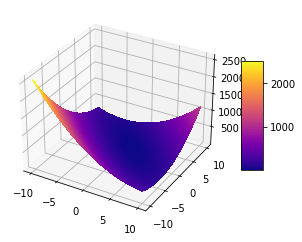

In [85]:
p = Plot(BoothFunction, domain)
p.render()

In [93]:
oracle = FirstOrderOracle(BoothFunction, domain)

Numeric solution was found in point  [0.99999965 3.00000035]  with value  2.4805157718763664e-13
True solution was found in point  [1 3]  with value  0
Method was stopped by accuracy with accuracy  9.980890133803976e-10  in  6271  iterations
Residual between numeric and true solutions is  4.980465263682547e-07


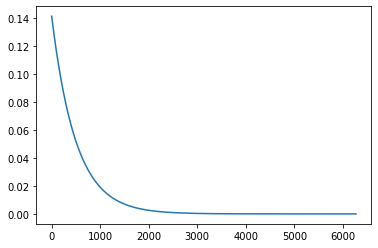

In [94]:
gd = GradientDescent(oracle, np.array([0.9, 3.1]), 1e-3, 1e-9, 10000)
task11 = Pipeline(gd)
task11.process()

Numeric solution was found in point  [0.99999973 3.00000027]  with value  1.4343395759847473e-13
True solution was found in point  [1 3]  with value  0
Method was stopped by accuracy with accuracy  9.983433683587043e-10  in  4873  iterations
Residual between numeric and true solutions is  3.7872512842556027e-07


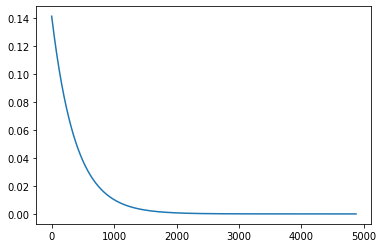

In [95]:
gd = MomentumGradientDescent(oracle, np.array([0.9, 3.1]), 1e-3, 1e-9, 10000)
task12 = Pipeline(gd)
task12.process()

Numeric solution was found in point  [0.99874256 3.00125744]  with value  3.162311321346075e-06
True solution was found in point  [1 3]  with value  0
Method was stopped by iterations with accuracy  6.919464980180177e-07
Residual between numeric and true solutions is  0.0017782888745489236


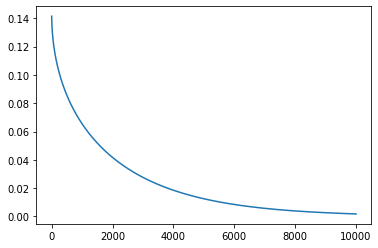

In [96]:
gd = AdaptiveGradientDescent(oracle, np.array([0.9, 3.1]), 1e-3, 1e-9, 10000)
task13 = Pipeline(gd)
task13.process()

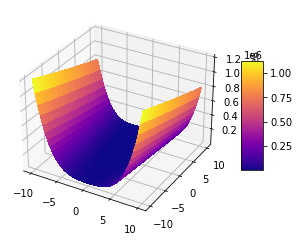

In [86]:
p = Plot(RosenbrokFunction, domain)
p.render()

In [98]:
oracle = FirstOrderOracle(RosenbrokFunction, domain)

Numeric solution was found in point  [1.0006485  1.00130002]  with value  4.212261134757687e-07
True solution was found in point  [1 1]  with value  0
Method was stopped by iterations with accuracy  5.802361582112387e-07
Residual between numeric and true solutions is  0.001452788696517523


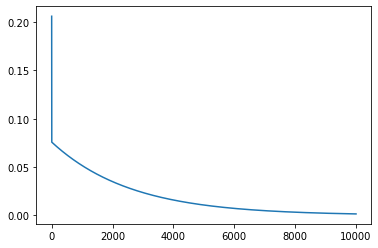

In [99]:
gd = GradientDescent(oracle, np.array([0.87, 1.16]), 1e-3, 1e-9, 10000)
task21 = Pipeline(gd)
task21.process()

Numeric solution was found in point  [1.00026932 1.00053978]  with value  7.264706548697784e-08
True solution was found in point  [1 1]  with value  0
Method was stopped by iterations with accuracy  2.918804464132517e-07
Residual between numeric and true solutions is  0.0006032371277944123


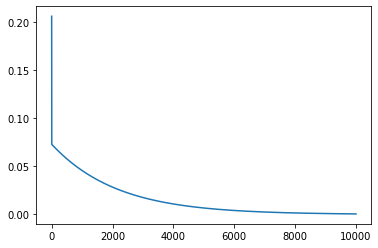

In [100]:
gd = MomentumGradientDescent(oracle, np.array([0.87, 1.16]), 1e-3, 1e-9, 10000)
task22 = Pipeline(gd)
task22.process()

Numeric solution was found in point  [1.00107691 1.03274789]  with value  0.0935938357188915
True solution was found in point  [1 1]  with value  0
Method was stopped by iterations with accuracy  3.1210819809029383e-06
Residual between numeric and true solutions is  0.032765593468322744


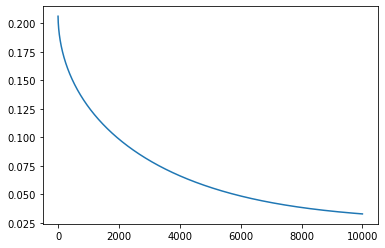

In [101]:
gd = AdaptiveGradientDescent(oracle, np.array([0.87, 1.16]), 1e-3, 1e-9, 10000)
task23 = Pipeline(gd)
task23.process()

Регулировка шага

In [81]:
class GradientDescentCorr():
    
    def __init__(self, 
                 oracle,
                 initial_point: np.ndarray, 
                 learning_rate: float = 1e-3,
                 accuracy: float = 1e-3,
                 max_iter: int   = 1e+3):
        self.__oracle        = oracle
        self.__init_point    = initial_point
        self.__lr            = learning_rate
        self.__acc           = accuracy
        self.__max_iter      = max_iter
        self.__found_p       = np.zeros(len(initial_point))
        self.__fount_fn      = 0.0
        self.__a             = 0.9
        self.__mu            = np.random.uniform(1e-9, 0.5)
        self.__g             = np.random.uniform(1e-9, 1.0)

    def correct_step(self, current_point: np.ndarray, fn: float, drv: np.ndarray) -> float:
        step       = self.__a
        next_fn, _ = self.__oracle.query(current_point + step * drv)
        norm       = np.linalg.norm(drv) ** 2

        while next_fn > fn + self.__mu * norm * step:
            step *= self.__g
            next_fn, _ = self.__oracle.query(current_point + step * drv)
            norm       = np.linalg.norm(drv) ** 2

        return step
    
    def step(self, current_point: np.ndarray) -> np.ndarray:
        fn, drv = self.__oracle.query(current_point)
        current_lr = self.correct_step(current_point, fn, drv)
        next_point = current_point - self.__lr * drv
        return next_point
        
    def solve(self):
        traj = []
        prev_point = copy(self.__init_point)
        next_point = self.step(prev_point)
        counter = 0
        
        traj.append(self.__init_point)
        traj.append(next_point)
        while np.linalg.norm(prev_point - next_point) >= self.__acc and counter < self.__max_iter:
            prev_point = next_point
            next_point = self.step(prev_point)
            traj.append(next_point)
            counter += 1
            
        self.__found_p  = next_point
        self.__found_fn = self.__oracle.query(next_point)[0]
        self.__trajectory = np.array(traj)

        by_acc: bool = True
        if np.linalg.norm(prev_point - next_point) >= self.__acc:
            by_acc = False
        
        return by_acc, np.linalg.norm(prev_point - next_point), counter
    
    def get_numeric_solution(self):
        return self.__found_p, self.__found_fn

    def get_true_solution(self):
        return self.__oracle.solution()

    def get_trajectory(self):
        return self.__trajectory